In [1]:
import math
import scipy
import scipy.io
import scipy.signal as s
import scipy.interpolate as interp
import matplotlib.pyplot as plt

import statsmodels.api as sm
import numpy as np

def todB(x): return 10 * np.log10(abs(x))
def amp(x): return 10**(x/10)

def t90(x):
    total = sum(x)
    peak = int(len(x)/2)
    for i in range(1,10000):
        if(sum(x[peak-i:peak+i])>=(0.9*total)):
            return 2*i/fs
    return -99999
    
#   t90(x) gradually increases a symetric window around the peak untill it reaches 90% of the total
#   returns the window size in units of seconds

full = scipy.io.loadmat('23B_121_86_FullGun.mat')
partial = scipy.io.loadmat('23B_123_409_NoGun.mat')

test = scipy.io.loadmat('MGL1212_Line_AT.mat')

f1 = full['Data1']
f2 = full['Data2']

p1 = partial['Data1']
p2 = partial['Data2']

f1=test['Data1']

f1=np.transpose(f1) #puts data on it's side (easier to work with rows)
f1=f1[::-1]#reverses 
f1 = f1*(10**6) #convert to micro pascals
fs = 500

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# I. High Pass Filter to remove streamer noise

#Applies 3 biquad filters with 11hz cutoff to remove streamer noise, parameters come from fdatool

sos=[[1,-2,1,1,-1.82570619168342,0.881881926844246],[1,-2,1,1,-1.65627993129105,0.707242535896459],[1,-2,1,1,-1.57205200320457,0.620422971870477]]

fData = []
for row in f1:
    fData.append(s.sosfilt(sos,row))
fData=np.asarray(fData)#recast as ndarray


In [3]:
# II. Adjusting for group length (+6dB)
fData = amp(6)*fData # adjusted filtered data

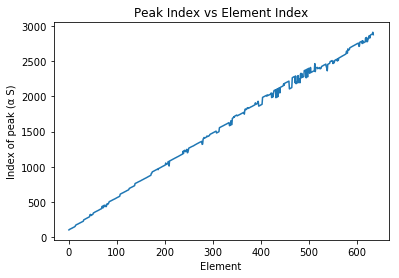

In [4]:
# III. Windowing Around Peak (2s before and after)
peak=[]
#forward 2 s
winData = []#windowed data
for row in fData:
    peak1 = np.argmax(row[0:10*fs])
    if(peak1>1000):#if the peak is 2s from the 0 index (window can be 4s)
        DATA = row[peak1-2*fs:peak1+2*fs]#Keep data around the peak (2s before and after)
    else:
        w = row[peak1:peak1+2*fs]#one-sided window
        wf = w#flipped window without the peak index
        wf=wf[::-1]
        wf=wf[0:len(wf)-1]
        DATA = np.concatenate((wf,w))#forward window of 2s mirrored around the peak
    winData.append(DATA)
    peak.append(peak1)
winData = np.asarray(winData)#recast as ndarray
plt.plot(peak)
plt.title('Peak Index vs Element Index')
plt.xlabel('Element')
plt.ylabel('Index of peak (α S)')
plt.show()


[ 123.85290099  197.75493442  198.2813007   198.15731332  196.82617816
  197.00029374  196.85535751  198.65565413  198.62548299  199.70871386
  197.85283931  197.89640075  196.76364129  197.13101193  193.2403416
  194.55976483  195.40032392  195.66491337  196.07228474  195.90348805
  196.93657355  197.01037855  197.17408792  197.78259397  197.86105329
  197.58833031  197.20680517  197.46309852  197.87195934  196.84981971
  196.85141322  193.44679712  193.27859191  195.16576641  195.38353899
  195.54637923  194.70290781  195.14994118  193.53815412  194.63925217
  194.48962024  192.84572687  194.79352751  193.65453347  167.51756083
  188.89489279  173.53051584  138.69079881  192.07676579  190.8350279
  190.46478228  181.03122084  183.07432622  107.01546126  190.25627524
  190.74854242  190.33302253  189.83568909  192.06131491  193.05683332
  192.4516266   192.64683916  192.83782246  192.59829592  192.90998582
  193.26773797  193.40835557  193.32995075  195.88005544  183.54226675
  182.39

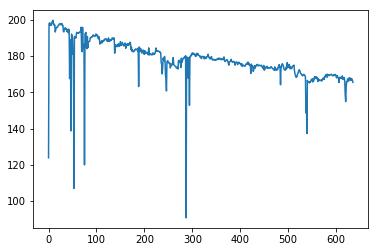

In [5]:
# IV. Calculate RMS of power

squaredPressure = np.multiply(winData,winData)

RMS = []
T90 = []
i = 0

for row in squaredPressure:
    T90a=t90(row)
    RMS.append(10*np.log10(sum(row)/(fs*T90a)))#integrate squared pressure / T90
    i = i+1
    T90.append(T90a)
RMS = np.asarray(RMS)#recast as ndarray
print(RMS)
print(T90)
plt.plot(RMS)
plt.show()

In [6]:
#IV. Calculate SEL Energy Density (dB)

SEL=[]

i = 0
for rms in RMS:
    SEL.append(rms+10*np.log10(T90[i]))# RMS + log(T90)
    i = i+1
SEL = np.asarray(SEL)#recast as ndarray
print(SEL)

scipy.io.savemat('Data1.mat', mdict={'SEL':SEL,'RMS':RMS,'Windowed': winData,'Filtered':fData,'Original':f1})#debug

[ 118.79444693  190.49651291  190.42973918  190.61243999  190.25040496
  190.50277392  190.27958432  192.00019164  190.55672898  190.35329375
  189.89403914  190.14949356  189.31636634  189.27945042  185.88851983
  186.26238198  186.735713    186.59913022  187.00650159  186.69530052
  187.58115344  187.80219102  187.96590039  188.57440643  188.50563318
  188.38014277  187.99861763  188.10767841  188.36413957  187.49439961
  187.18565077  184.38101398  184.07040437  185.8103463   185.87571922
  186.03855945  185.3474877   185.94175364  184.8735432   185.97464125
  185.82500932  184.30700723  186.1289166   184.98992256  159.55876065
  180.35617314  164.17509574  144.06143024  182.07676579  181.16926546
  180.79901983  172.36660993  174.14642592  106.08957487  180.90085513
  181.39312231  180.97760242  180.48026898  182.7058948   183.84864578
  183.52372629  183.71893885  183.62963492  183.24287581  183.55456571
  183.91231786  184.20016803  184.12176321  186.52463534  176.88680426
  175.

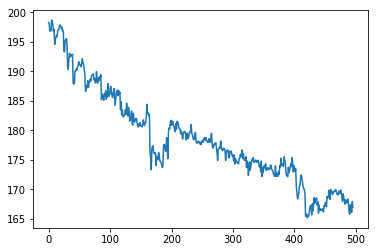

inaccurate: [0, 9, 11, 14, 28, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 57, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 86, 102, 105, 106, 133, 134, 135, 136, 137, 138, 170, 171, 181, 182, 183, 184, 185, 187, 188, 209, 229, 230, 231, 232, 233, 234, 237, 239, 240, 241, 242, 243, 244, 245, 246, 254, 260, 267, 268, 270, 276, 278, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 294, 422, 427, 484, 488, 498, 509, 510, 511, 512, 513, 518, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 606, 613, 614, 615, 616, 617, 618, 619, 620, 621] 
noisy: [1, 54, 189, 295, 540, 629, 630, 631, 632, 633, 634, 635]


In [35]:
#V. Remove noisy or inaccurate channels
RMS2=RMS.tolist()
SEL2=SEL.tolist()
RMS_diff=[]
inaccurate=[]
noisy=[]
N=8
RMS_avg = np.convolve(RMS, np.ones((N,))/N, mode='valid')#rolling average of RMS
RMS_avg = np.concatenate((RMS_avg,RMS[len(RMS_avg):len(RMS_avg)+N-1]))#pad RMS_avg

for i in range(1,len(RMS)):
    RMS_diff.append(np.abs(RMS[i]-RMS[i-1]))#differential RMS
RMS_diff.insert(0,999)#remove first index from consideration and shift the index back
RMS_diff_avg = np.convolve(RMS_diff, np.ones((N,))/N, mode='valid')#rolling average of differential RMS
RMS_diff_avg = np.concatenate((RMS_diff_avg,RMS[len(RMS_diff_avg):len(RMS_diff_avg)+N-1]))#pad


for i in range(0,len(RMS)):
    if(np.abs(RMS_avg[i]-RMS[i])>2):#inacurate
        inaccurate.append(i)
    elif(np.abs(RMS_diff[i]-RMS_diff_avg[i])>15):#noisy
        noisy.append(i)

        
indexes = list(set(np.concatenate((inaccurate,noisy))))#consolidate
for index in sorted(indexes, reverse=True):#remove bad channels
    del RMS2[int(index)]#reversed so that removing doesn't effect the following indexes
    del SEL2[int(index)]
    del RMS_diff[int(index)]
#plt.plot(RMS2)
plt.plot(RMS2)
#plt.hist(RMS_diff)
#print(np.mean(RMS_diff))
plt.show()
print('inaccurate:',inaccurate,'\nnoisy:',noisy)


In [ ]:
#VI. Fitting Data
b = np.linspace(0,len(RMS2),len(RMS2))

'''SELmodel = np.polyfit(b, SEL2, deg=8)
RMSmodel = np.polyfit(b, RMS2, deg=8)

SELpol = np.poly1d(SELmodel) 
RMSpol = np.poly1d(RMSmodel)

SEL180 = -1
SEL160 = -1
RMS180 = -1
RMS160 = -1

for i in range(0,1000):
    if(SELpol(i)>180):
        SEL180 = i
    if(SELpol(i)>160):
        SEL160 = i
    if(RMSpol(i)>180):
        RMS180 = i
    if(RMSpol(i)>160):
        RMS160 = i
SEL180 = SEL180*(12.5/1000)#converts from index to length in km
SEL160 = SEL160*(12.5/1000)
RMS180 = RMS180*(12.5/1000)
RMS160 = RMS160*(12.5/1000)

print('SEL180 =',SEL180)#Safety radii
print('SEL160 =',SEL160)
print('RMS180 =',RMS180)
print('RMS160 =',RMS160)

plt.plot(b,SELpol(b))
plt.show()'''